In [1]:
#!git clone "https://github.com/jyanivaddi/ERA_V1.git"
#!git pull

Cloning into 'ERA_V1'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 384 (delta 84), reused 97 (delta 43), pack-reused 237
Receiving objects: 100% (384/384), 5.63 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (202/202), done.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_8")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from s8_utils import load_cifar10_data, preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions
from s8_model import Model_Net, model_summary, model_train, model_test

Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
cifar_10_model = Model_Net(norm_type = 'group_norm', num_groups = 2).to(device)
model_summary(cifar_10_model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
         GroupNorm-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             256
        GroupNorm-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1

/content/ERA_V1/session_8/s8_model.py:199: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.244, 0.262))
])

Download Data

In [5]:
train_data, test_data, class_names = load_cifar10_data(train_transforms, test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 13114172.44it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Define train and test loaders

In [6]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, **kwargs)

Calculate Mean and Std of dataset

In [7]:
from tqdm import tqdm
import numpy as np
mean_r = 0
mean_g = 0
mean_b = 0

std_r = 0
std_g = 0
std_b = 0
loader_for_stats = test_loader
for img,_ in tqdm(loader_for_stats):
    img = np.asarray(img)
    # calculate Mean of Normalized dataset
    mean_r += np.mean(img[:,0,:,:])
    mean_g += np.mean(img[:,1,:,:])
    mean_b += np.mean(img[:,2,:,:])
    # calculate std of Normalized dataset
    std_r += np.var(img[:,0,:,:])
    std_g += np.var(img[:,1,:,:])
    std_b += np.var(img[:,2,:,:])
mean_r = mean_r / len(loader_for_stats)
mean_g = mean_g / len(loader_for_stats)
mean_b = mean_b / len(loader_for_stats)
std_r = np.sqrt(((1./(len(loader_for_stats)-1))*std_r))
std_g = np.sqrt(((1./(len(loader_for_stats)-1))*std_g))
std_b = np.sqrt(((1./(len(loader_for_stats)-1))*std_b))
print(f"dataset mean: {mean_r:0.3f}, {mean_g:0.3f}, {mean_b:0.3f}")
print(f"dataset std: {std_r:0.3f}, {std_g:0.3f}, {std_b:0.3f}")


100%|██████████| 79/79 [00:02<00:00, 29.89it/s]

dataset mean: 0.013, 0.014, 0.015
dataset std: 1.005, 1.002, 1.004


Show sample Images

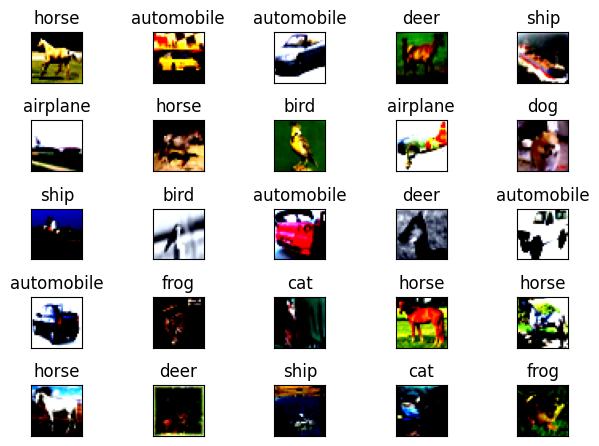

In [9]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

In [11]:
def detect_cifar_images(norm_type):
    model = Model_Net(norm_type='norm_type').to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    for epoch in range(1,20):
        print(f"epoch: {epoch}")
        this_train_loss = model_train(model, device, train_loader, optimizer, train_acc, train_losses)
        this_loss = model_test(model, device, test_loader, test_acc, test_losses)
        #scheduler.step()
        #print(optimizer.)
    target_test_acc = 70.
    plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc)
    incorrect_predictions = get_incorrect_predictions(model, test_loader, device)
    show_incorrect_predictions(incorrect_predictions, class_names, num_rows = 2, num_cols = 5)
    return model, train_losses, train_acc, test_losses, test_acc

Train Model using Batch Normalization

In [ ]:
bn_model, bn_train_losses, bn_train_acc, bn_test_losses, bn_test_acc = detect_cifar_images(norm_type='batch_norm')

Train Model using Layer Normalization

In [ ]:
ln_model, ln_train_losses, ln_train_acc, ln_test_losses, ln_test_acc = detect_cifar_images(norm_type='layer_norm')

Train Model using Group Normalization

In [ ]:
gn_model, gn_train_losses, gn_train_acc, gn_test_losses, gn_test_acc = detect_cifar_images(norm_type='group_norm')

In [10]:
model = Model_Net(norm_type='batch_norm').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1,20):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(model, device, train_loader, optimizer, train_acc, train_losses)
    this_loss = model_test(model, device, test_loader, test_acc, test_losses)
    #scheduler.step()
    #print(optimizer.)


epoch: 1


  0%|          | 0/391 [00:00<?, ?it/s]/content/ERA_V1/session_8/s8_model.py:199: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=1.2049589157104492 batch_id=390 Accuracy = 41.20: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]



Test set: Average loss: 1.3475, Accuracy: 5069/10000 (50.69%)

epoch: 2


loss=1.0276237726211548 batch_id=390 Accuracy = 58.85: 100%|██████████| 391/391 [00:17<00:00, 21.92it/s]



Test set: Average loss: 1.2439, Accuracy: 5488/10000 (54.88%)

epoch: 3


loss=1.2074750661849976 batch_id=390 Accuracy = 64.93: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]



Test set: Average loss: 1.1510, Accuracy: 5886/10000 (58.86%)

epoch: 4


loss=0.8665307760238647 batch_id=390 Accuracy = 68.02: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 0.9486, Accuracy: 6672/10000 (66.72%)

epoch: 5


loss=0.845132052898407 batch_id=390 Accuracy = 70.27: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]



Test set: Average loss: 0.8473, Accuracy: 6953/10000 (69.53%)

epoch: 6


loss=0.9287925958633423 batch_id=390 Accuracy = 72.32: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]



Test set: Average loss: 0.7943, Accuracy: 7159/10000 (71.59%)

epoch: 7


loss=0.6030462980270386 batch_id=390 Accuracy = 73.61: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]



Test set: Average loss: 0.7951, Accuracy: 7187/10000 (71.87%)

epoch: 8


loss=0.8370992541313171 batch_id=390 Accuracy = 74.96: 100%|██████████| 391/391 [00:19<00:00, 20.06it/s]



Test set: Average loss: 0.8695, Accuracy: 6955/10000 (69.55%)

epoch: 9


loss=0.5410507321357727 batch_id=390 Accuracy = 76.06: 100%|██████████| 391/391 [00:21<00:00, 18.32it/s]



Test set: Average loss: 0.7923, Accuracy: 7199/10000 (71.99%)

epoch: 10


loss=0.5090135931968689 batch_id=390 Accuracy = 76.75: 100%|██████████| 391/391 [00:20<00:00, 19.52it/s]



Test set: Average loss: 0.7915, Accuracy: 7224/10000 (72.24%)

epoch: 11


loss=0.7404916882514954 batch_id=390 Accuracy = 77.61: 100%|██████████| 391/391 [00:19<00:00, 19.56it/s]



Test set: Average loss: 0.8447, Accuracy: 7064/10000 (70.64%)

epoch: 12


loss=0.5500799417495728 batch_id=390 Accuracy = 78.37: 100%|██████████| 391/391 [00:20<00:00, 18.68it/s]



Test set: Average loss: 0.6756, Accuracy: 7661/10000 (76.61%)

epoch: 13


loss=0.5356391668319702 batch_id=390 Accuracy = 79.02: 100%|██████████| 391/391 [00:18<00:00, 21.68it/s]



Test set: Average loss: 0.7362, Accuracy: 7428/10000 (74.28%)

epoch: 14


loss=0.5258834362030029 batch_id=390 Accuracy = 79.40: 100%|██████████| 391/391 [00:20<00:00, 18.68it/s]



Test set: Average loss: 0.7324, Accuracy: 7404/10000 (74.04%)

epoch: 15


loss=0.4695872664451599 batch_id=390 Accuracy = 79.87: 100%|██████████| 391/391 [00:19<00:00, 19.57it/s]



Test set: Average loss: 0.6655, Accuracy: 7667/10000 (76.67%)

epoch: 16


loss=0.583649218082428 batch_id=390 Accuracy = 80.28: 100%|██████████| 391/391 [00:20<00:00, 19.04it/s]



Test set: Average loss: 0.6715, Accuracy: 7646/10000 (76.46%)

epoch: 17


loss=0.6665527820587158 batch_id=390 Accuracy = 80.68: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.6789, Accuracy: 7654/10000 (76.54%)

epoch: 18


loss=0.5526965856552124 batch_id=390 Accuracy = 81.17: 100%|██████████| 391/391 [00:18<00:00, 21.26it/s]



Test set: Average loss: 0.6269, Accuracy: 7814/10000 (78.14%)

epoch: 19


loss=0.6050540804862976 batch_id=390 Accuracy = 81.41: 100%|██████████| 391/391 [00:17<00:00, 21.76it/s]



Test set: Average loss: 0.6838, Accuracy: 7698/10000 (76.98%)



Plot Statistics

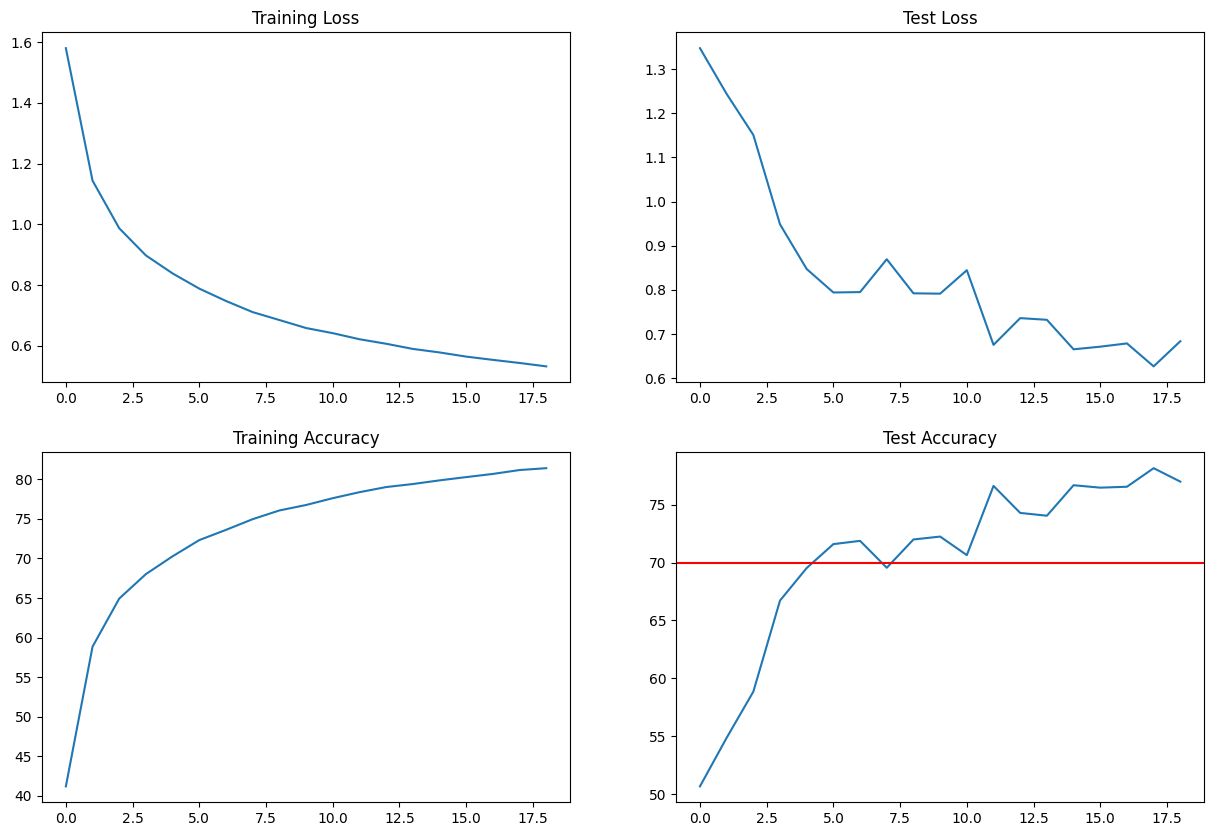

In [12]:
target_test_acc = 70.
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc)

Show Incorrect Predictions

In [15]:
incorrect_predictions = get_incorrect_predictions(model, test_loader, device)
incorrect_predictions[0]
#show_incorrect_predictions(incorrect_predictions, class_names, num_rows = 2, num_cols = 5)

/content/ERA_V1/session_8/s8_model.py:199: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[tensor([[[-1.5433, -1.5909, -1.6068,  ..., -0.9082, -0.9082, -0.9241],
          [-1.5592, -1.5909, -1.5909,  ..., -0.6224, -0.7177, -0.5907],
          [-1.6227, -1.6227, -1.6068,  ..., -0.1620,  0.1714,  0.2984],
          ...,
          [ 0.1873,  0.3619,  0.7271,  ..., -1.5909, -1.5433, -1.6068],
          [ 0.2190,  0.1555,  0.5207,  ..., -1.5751, -1.5433, -1.5909],
          [ 0.4572, -0.1303,  0.2190,  ..., -1.5274, -1.4957, -1.5433]],
 
         [[-1.8147, -1.8468, -1.8468,  ..., -1.5897, -1.6218, -1.6379],
          [-1.8308, -1.8308, -1.8147,  ..., -1.4611, -1.5415, -1.4290],
          [-1.7665, -1.7825, -1.7986,  ..., -1.1075, -0.7539, -0.6896],
          ...,
          [-0.7861, -0.5771, -0.0146,  ..., -1.8308, -1.8308, -1.8147],
          [-0.6736, -0.8022, -0.2557,  ..., -1.7986, -1.8147, -1.8147],
          [-0.4004, -1.0432, -0.5932,  ..., -1.7986, -1.7825, -1.7986]],
 
         [[-1.4666, -1.4966, -1.4966,  ..., -1.3618, -1.3918, -1.5415],
          [-1.4816, -1.4816,